# Oil Sector ETF Pairs Trade Research Notebook

Author: Mark Black
Date: 6/21/2017

This research notebook explores the potential for a Pairs Trade/Mean Reversion setup in the oil service space. The securities we will be exporing are: OIH, XOP, XLE, XES.

In [124]:
# First we have to import the necessary libraries
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

import matplotlib.pyplot as plt

In [125]:
# Function to find cointegrated pairs
# This function will be called later in the notebook when we test for cointegration amongst the 4 ETF's

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [129]:
# Later in the research we will find that there appears to be cointegration betweem OIH & XOP
# so we will test the pair below.
# First we must import daily closing prices and convert them into returns

start = '2012-01-01'
end = '2017-06-20'

S1 = get_pricing('OIH', start_date=start, end_date=end, frequency='daily')['price']
S2 = get_pricing('XOP', start_date=start, end_date=end, frequency='daily')['price']

S1_pct = get_pricing('OIH', start_date=start, end_date=end, frequency='daily').pct_change()
S2_pct = get_pricing('XOP', start_date=start, end_date=end, frequency='daily').pct_change()

S1_pct = S1_pct['price'].dropna()
S2_pct = S2_pct['price'].dropna()
type(S1_pct)

<class 'pandas.core.series.Series'>

In [128]:
# We want to make sure the 2 series have the number of observations
len(S2_pct) == len(S1_pct)

True

## Testing for Cointegration

Testing for cointegration: stats.models.tsa.stattools. p-value is a binary cutoff. Common use is confidence level: 0.05

In [100]:
# Compute the p-value of the cointegration test to test for cointegration
# Spread will show if timeseries is stationary around its mean

if len(S2_pct) == len(S1_pct):
    score, pvalue, _=coint(S1_pct, S2_pct)
    print pvalue
    
    if pvalue < 0.05:
        print 'Pairs look to be cointegrated and are eligible for pairs trading'

else:
    print "Error the number of observations for each pair does not match"

0.0
Pairs look to be cointegrated and are eligible for pairs trading


### WARNING: This will incur a large amount of multiple comparisons bias.
The methods for finding viable pairs all live on a spectrum. At one end there is the formation of an economic hypothesis for an individual pair. You have some extra knowledge about an economic link that leads you to believe that the pair is cointegrated, so you go out and test for the presence of cointegration. In this case you will incur no multiple comparisons bias. At the other end of the spectrum, you perform a search through hundreds of different securities for any viable pairs according to your test. In this case you will incur a very large amount of multiple comparisons bias. 

Multiple comparisons bias is the increased chance to incorrectly generate a significant p-value when many tests are run. If 100 tests are run on random data, we should expect to see 5 p-values below $0.05$ on expectation. Because we will perform $n(n-1)/2$ comparisons, we should expect to see many incorrectly significant p-values. For the sake of example will will ignore this and continue. In practice a second verification step would be needed if looking for pairs this way. Another approach is to pick a small number of pairs you have reason to suspect might be cointegrated and test each individually. This will result in less exposure to multiple comparisons bias. You can read more about multiple comparisons bias [here](https://en.wikipedia.org/wiki/Multiple_comparisons_problem).

In [122]:
symbol_list = ['OIH', 'XOP', 'XLE', 'XES']
prices_df = get_pricing(symbol_list, fields=['price'],
                       start_date=start, end_date=end)['price']
prices_df.columns = map(lambda x: x.symbol, prices_df.columns)

[(u'OIH', u'XOP')]


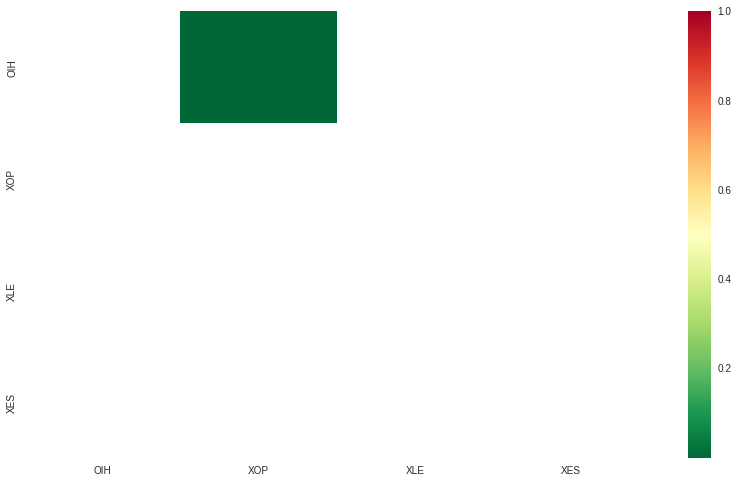

In [123]:
# Heatmap to show p-values of the cointegration test between each pair of stocks.
# Only show the value in the upper-diagnol of the heatmap

score, pvalues, pairs = find_cointegrated_pairs(prices_df)
import seaborn
seaborn.heatmap(pvalues, xticklabels=symbol_list, yticklabels=symbol_list, cmap='RdYlGn_r',
               mask = (pvalues >= 0.05))
print pairs

It looks like OIH and XOP are potential pairs candidates.

## Plotting the OIH & XOP & the Pairs Spread

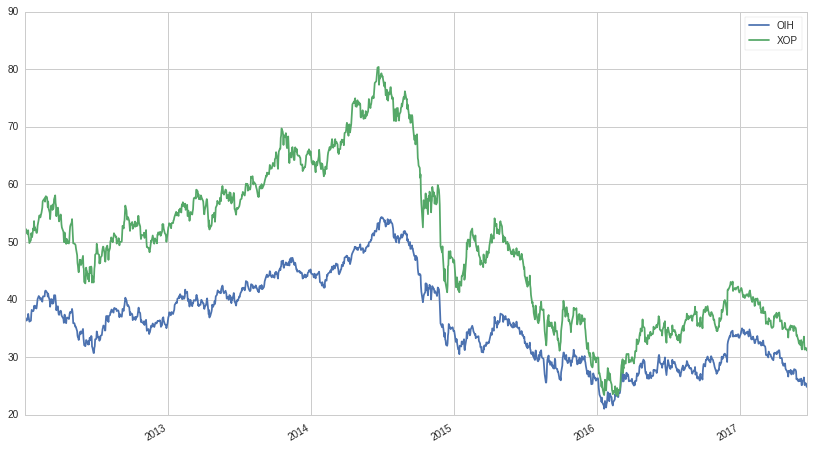

In [96]:
S1.plot()
S2.plot()
plt.legend(['OIH', 'XOP']);

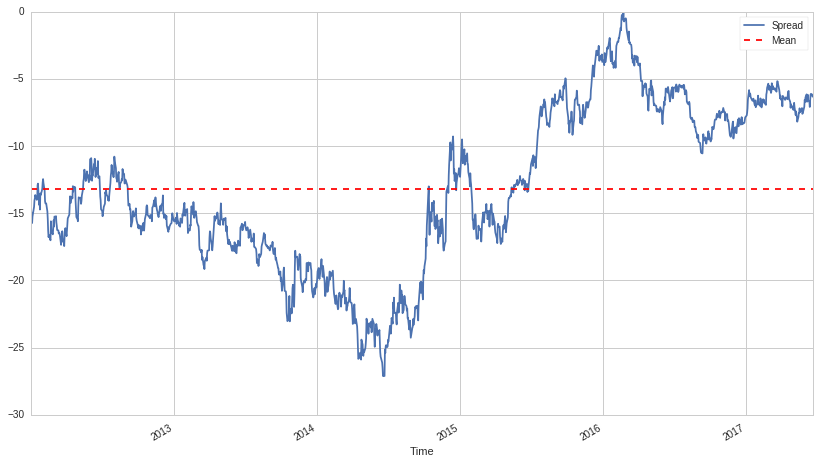

In [101]:
# Plot the spread between SNAP & FB
spread = S1 - S2
spread.plot()
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean line
plt.xlabel('Time')
plt.legend(['Spread', 'Mean'])

## Test for Correlation

In [61]:
S1_pct.corr(S2_pct)

0.15780110819786503

## MA for the Rolling Beta Spread

- Create a 20 day MAVG for the Spread & compare against 1 day MAVG spread
- Use a rolling beta

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://statsmodels.sourceforge.net/stable/regression.html
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=1,center=False).mean()
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  from ipykernel import kernelapp as app


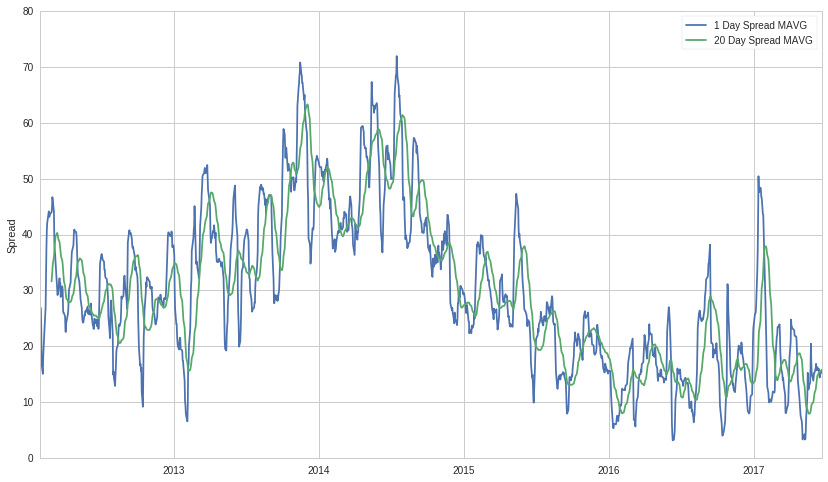

In [137]:
# S1 = get_pricing('SNAP', start_date=start, end_date=end, frequency='daily')['price']
# S2 = get_pricing('FB', start_date=start, end_date=end, frequency='daily')['price']

# Get the spread between 2 stocks
# Calculate the rolling beta coefficient
rolling_beta = pd.ols(y=S1, x=S2, window_type='rolling', window=20)
spread = S2 - rolling_beta.beta['x']*S1
spread.name = 'spread'

# Get the 1 day MA of the price spread
spread_mavg1 = pd.rolling_mean(spread, window=1)
spread_mavg1.name = 'spread 1d mavg'

# Get the 5 day MA
spread_mavg20 = pd.rolling_mean(spread, window=20)
spread_mavg20.name = 'spread 20d mavg'

plt.plot(spread_mavg1.index, spread_mavg1.values)
plt.plot(spread_mavg20.index, spread_mavg20.values)

plt.legend(['1 Day Spread MAVG', '20 Day Spread MAVG'])

plt.ylabel('Spread');

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()
  


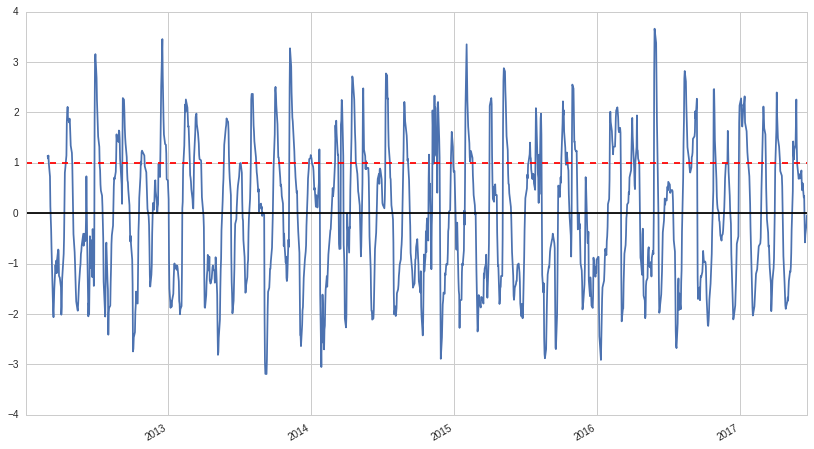

In [139]:
# Take a rolling 20 day STD
std_20 = pd.rolling_std(spread, window=20)
std_20.name = 'std_2d'

# Compute the z score for each day
zscore_20_1 = (spread_mavg1 - spread_mavg20)/std_20
zscore_20_1.name = 'z-score'
zscore_20_1.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', ls='--');

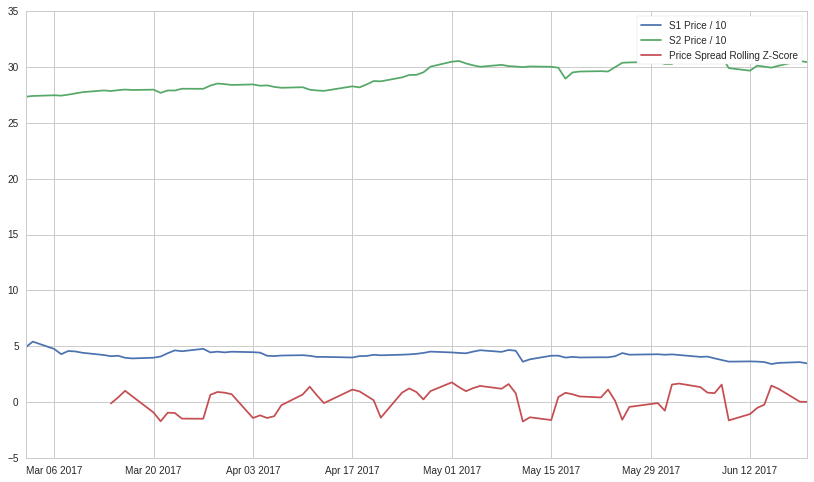

In [75]:
# Plot the prices scaled down along wtih the negative z-score
# just divide the stock prices by 5 to make viewable

plt.plot(S1.index, S1.values/5)
plt.plot(S2.index, S2.values/5)
plt.plot(zscore_5_1.index, zscore_5_1.values)
plt.legend(['S1 Price / 10', 'S2 Price / 10', 'Price Spread Rolling Z-Score']);

# Calculating the Spread

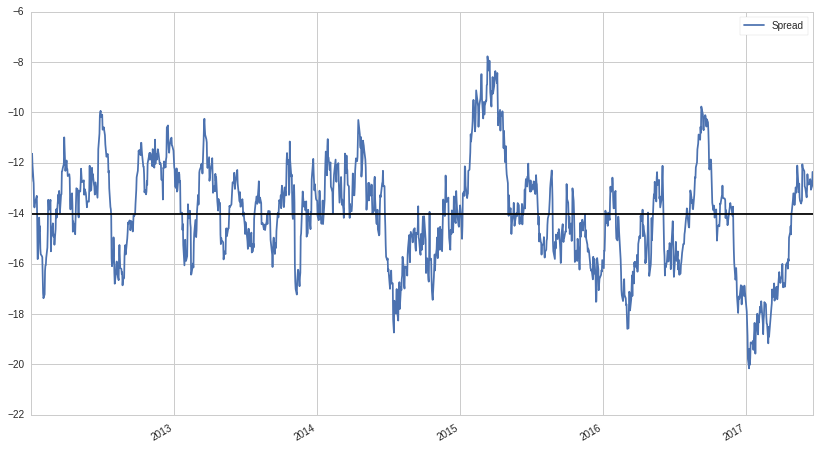

In [115]:
#S1.columns = ['OIH']

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['price']
b = results.params['price']

spread = S2 - b * S1
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

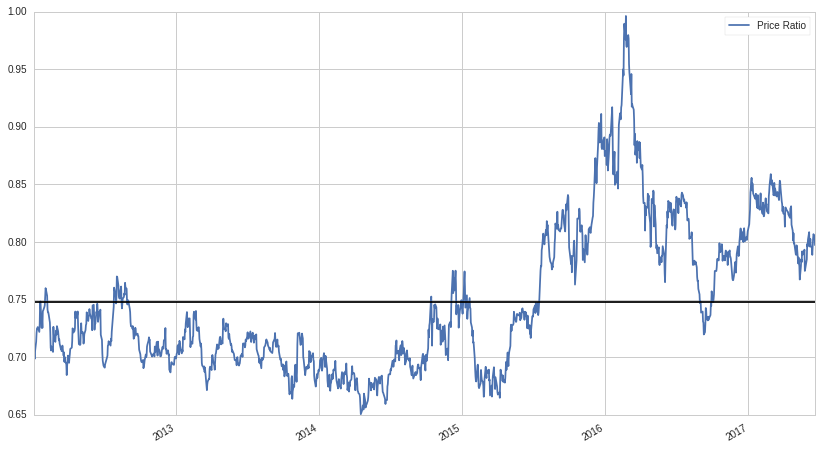

In [116]:
ratio = S1/S2
ratio.plot()
plt.axhline(ratio.mean(), color='black')
plt.legend(['Price Ratio']);

In [117]:
def zscore(series):
    return (series-series.mean())/np.std(series)

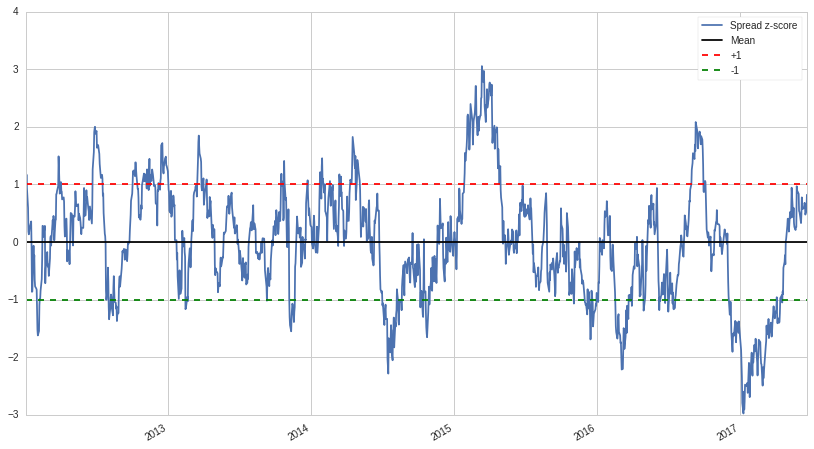

In [118]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', ls='--')
plt.axhline(-1.0, color='green', ls='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

## Backtest Anylsis

We use Quantopian's builtin function get_backtest to see break down the performance of how well this particular mean reversion strategy performed during the designated time period

Here is the backtest link: https://www.quantopian.com/algorithms/594aacc05619120010d4c7d8/594afbc93f06636a03e9ad95#backtest

In [131]:
bt = get_backtest('594afbc93f06636a03e9ad95')

100% Time: 0:00:01|###########################################################|


Entire data start date: 2013-01-02
Entire data end date: 2017-06-20


Backtest Months: 53


Performance statistics,Backtest
annual_return,0.02
cum_returns_final,0.11
annual_volatility,0.05
sharpe_ratio,0.47
calmar_ratio,0.20
stability_of_timeseries,0.47
max_drawdown,-0.12
omega_ratio,1.09
sortino_ratio,0.69
skew,0.11


Worst drawdown periods,net drawdown in %,peak date,valley date,recovery date,duration
0,11.60,2015-12-21,2016-08-19,NaT,NaN
1,3.56,2013-06-21,2013-11-15,2014-03-05,184
2,3.40,2015-07-08,2015-08-25,2015-12-18,118
3,3.01,2014-03-20,2014-07-16,2014-10-13,148
4,2.90,2015-01-20,2015-02-09,2015-03-23,45




[-0.006 -0.014]


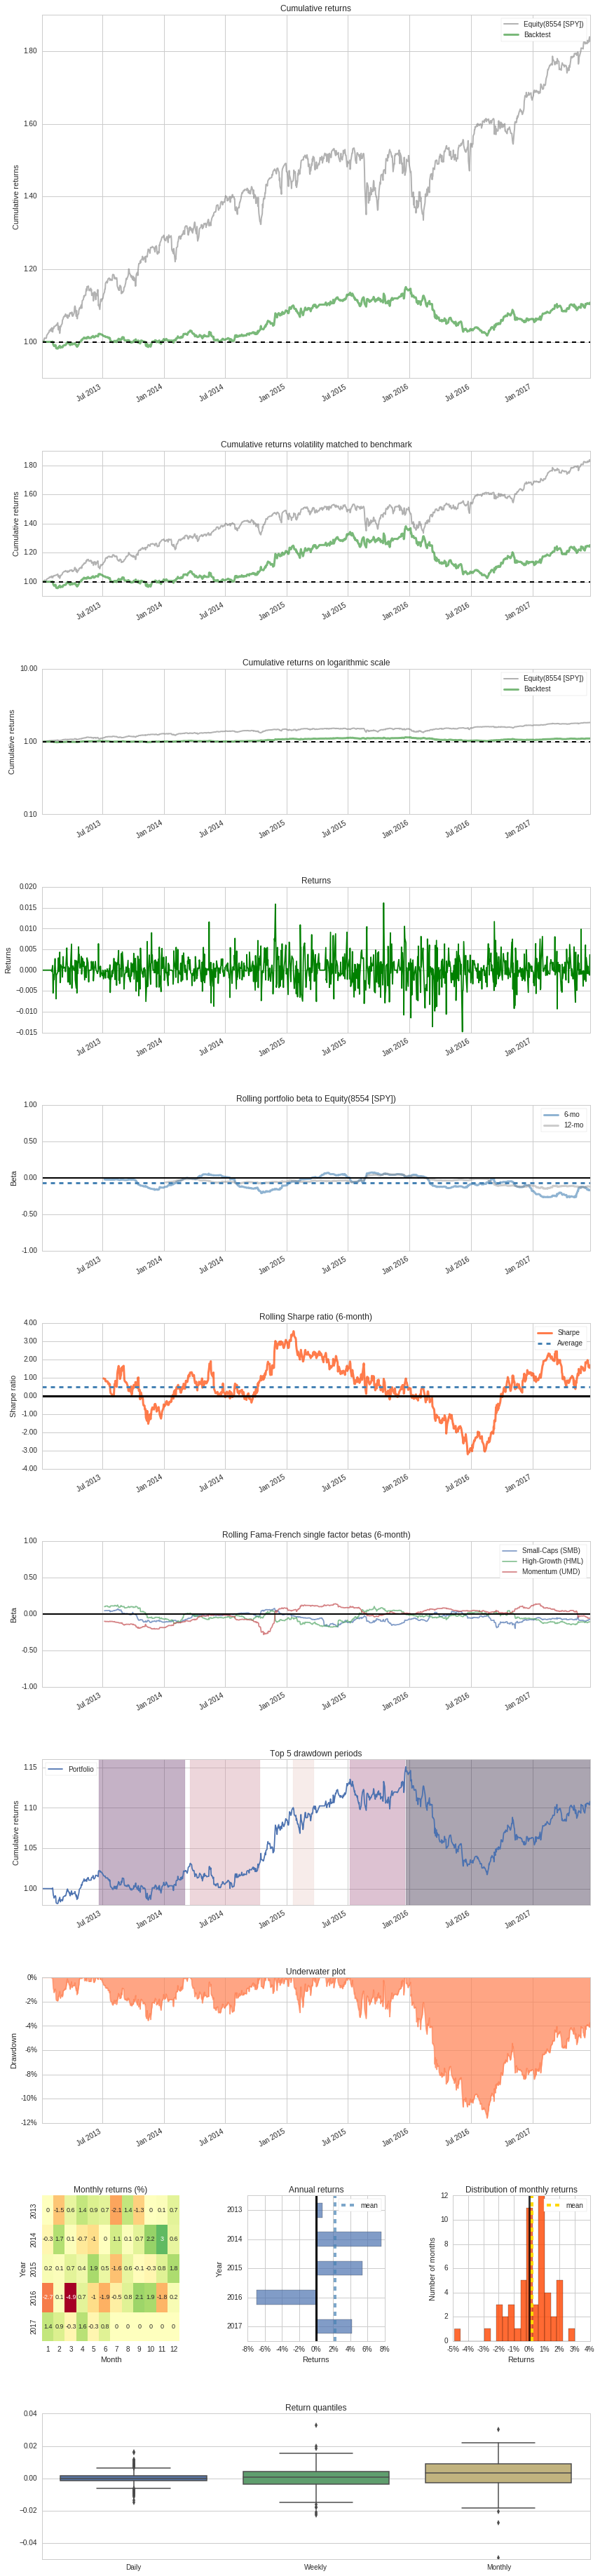

Stress Events,mean,min,max
Apr14,-0.02%,-0.51%,0.55%
Oct14,0.10%,-0.73%,0.71%
Fall2015,-0.01%,-0.80%,1.05%
New Normal,0.01%,-1.48%,1.62%


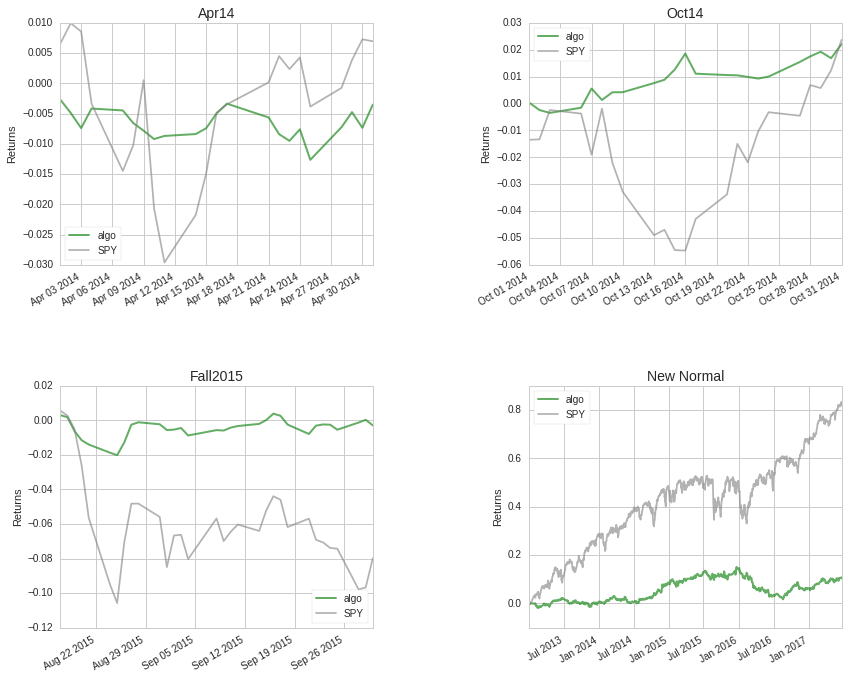

Top 10 long positions of all time,max
XLE-19655,38.48%
OIH-42304,34.15%
XOP-32279,28.09%
XES-32276,20.46%


Top 10 short positions of all time,max
XLE-19655,-49.16%
OIH-42304,-44.94%
XOP-32279,-31.93%
XES-32276,-25.92%


Top 10 positions of all time,max
XLE-19655,49.16%
OIH-42304,44.94%
XOP-32279,31.93%
XES-32276,25.92%


All positions ever held,max
XLE-19655,49.16%
OIH-42304,44.94%
XOP-32279,31.93%
XES-32276,25.92%


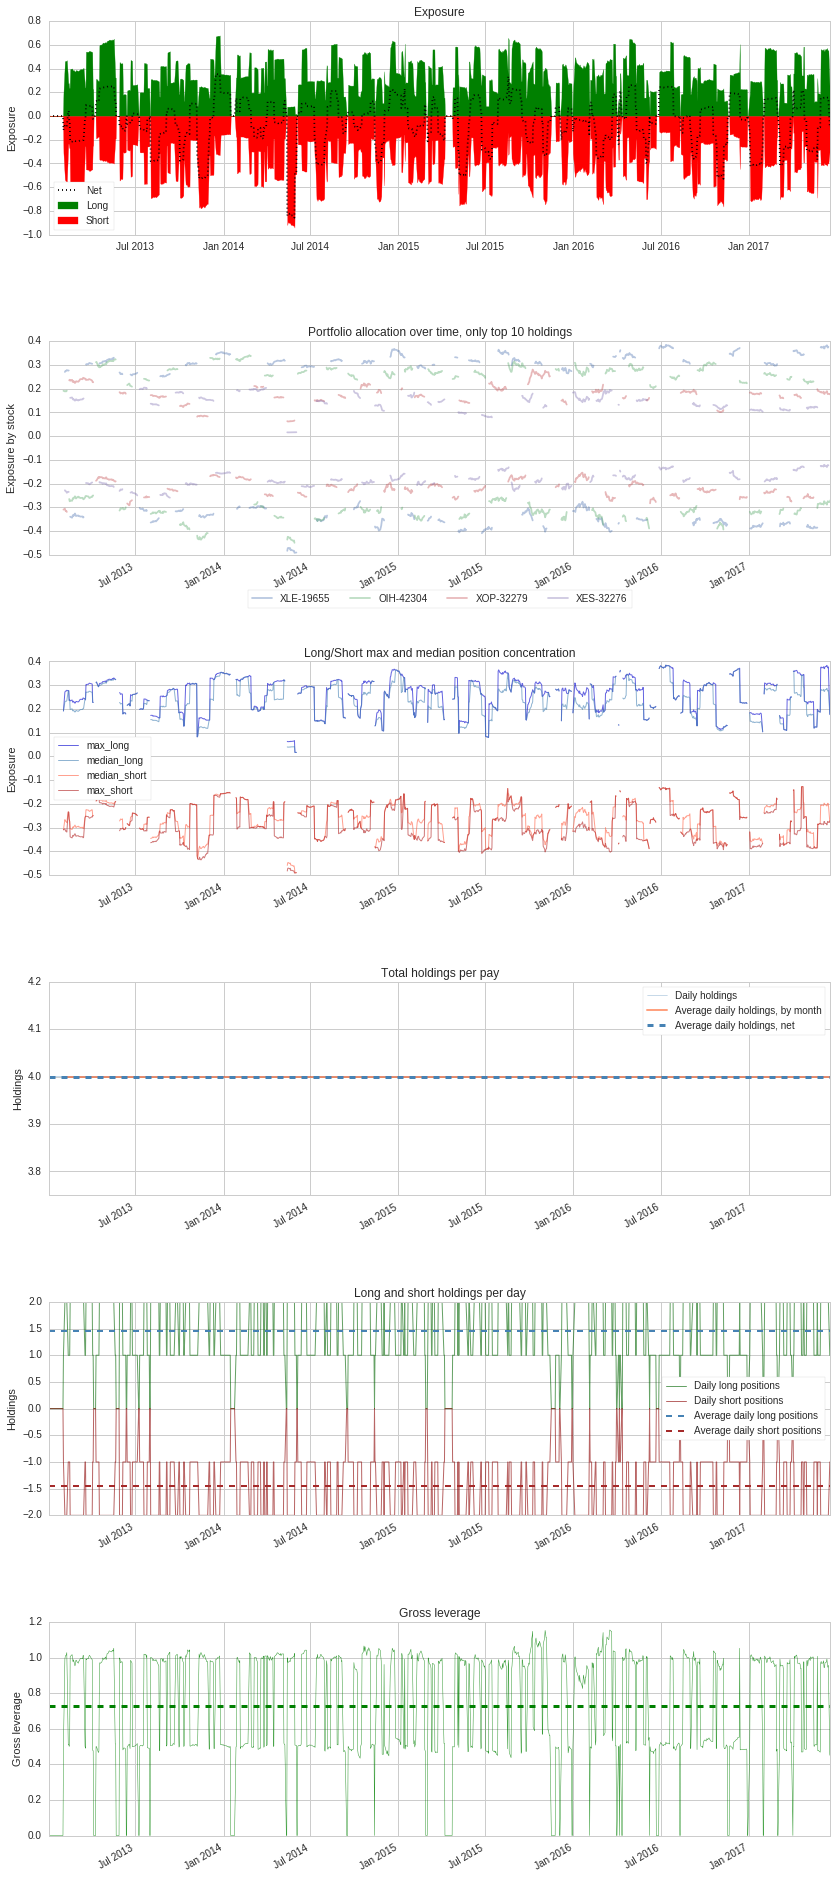

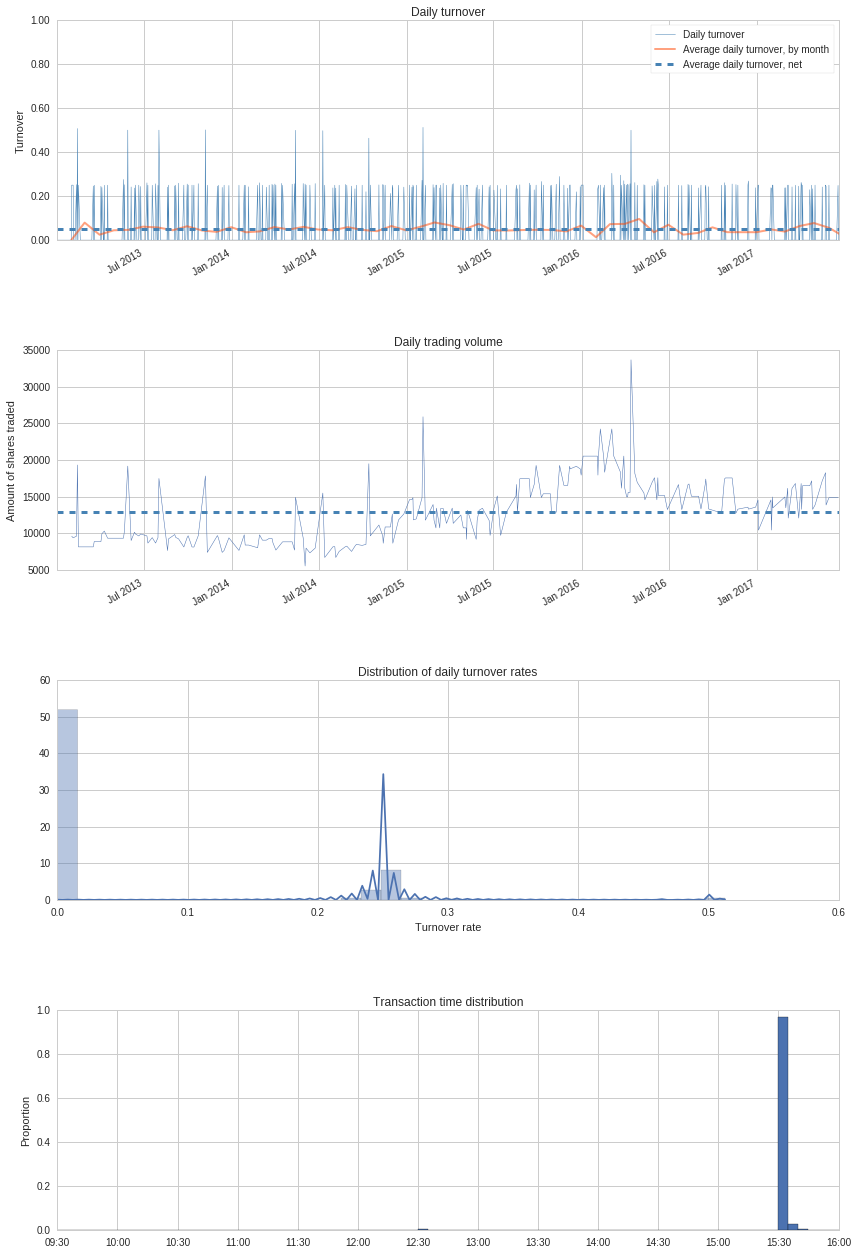

In [132]:
bt.create_full_tear_sheet()

## Conclusion

As you can see the backtest does not even begin to meet my top 3 criteria:

1. Superior returns compared to a benchmark (in this case the S&P500) 

2. Sharpe Ratio in excessive of 1.00 preferrably much higher as once deployed in live trading the Sharpe will most likely drastically lag the backtest

3. Low Drawdowns ideally below 20% including during the financial crisis. 

Some things that may improve performance are playing around with the z-score thresholds, different oil service sector ETF's, leverage... 

Unfortunately the available backtest historical data for these particular 2 ETF's is limited to post 2012. We cannot see how this particular strategy stands up during the 2008-2009 financial crisis.

## Further Research
This notebook contained some simple introductory approaches. In practice one should use more sophisticated statistics, some of which are listed here.

* Augmented-Dickey Fuller test 
* Hurst exponent
* Half-life of mean reversion inferred from an Ornstein–Uhlenbeck process
* Kalman filters

Disclaimer: This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company. In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.